# Reducción de Dimensionalidad - Crímenes en Chicago

## Importar Librerías y Cargar Datos

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Cargar dataset
df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_standardized_combined.csv")
test_df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_standardized_test.csv")
print(f"\nColumnas: {list(df.columns)}")

df = df.drop(["Unnamed: 0", "Latitude_standardized", "Longitude_standardized"], axis=1, errors='ignore')
test_df = test_df.drop(["Unnamed: 0", "Latitude_standardized", "Longitude_standardized"], axis=1, errors='ignore')

print(f"Shape del dataset: {df.shape}")
print(f"\nColumnas: {list(df.columns)}")
df.head()


Columnas: ['Beat', 'Ward', 'Community Area', 'Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night', 'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq', 'Location_Description_freq', 'FBI_Code_freq', 'Crime_District_freq', 'Nearest_Police_Station_District_freq', 'Nearest_Police_Station_District_Name_freq', 'X Coordinate_standardized', 'Y Coordinate_standardized', 'Latitude_standardized', 'Longitude_standardized', 'Distance Crime To Police Station_standardized', 'Arrest_tag']
Shape del dataset: (194897, 22)

Columnas: ['Beat', 'Ward', 'Community Area', 'Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night', 'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq', 'Location_Description_freq', 'FBI_Code_freq', 'Crime_District_freq', 'Nearest_Police_Station_District_freq', 'Nearest_Police_Station_District_Name_freq', 'X Coordinate_standardized', 'Y Coordinate_s

,Beat,Ward,Community Area,Day_sin,Season_Spring,Season_Summer,Season_Winter,Day Time_Early Morning,Day Time_Morning,Day Time_Night,...,Primary_Type_freq,Location_Description_freq,FBI_Code_freq,Crime_District_freq,Nearest_Police_Station_District_freq,Nearest_Police_Station_District_Name_freq,X Coordinate_standardized,Y Coordinate_standardized,Distance Crime To Police Station_standardized,Arrest_tag
0,2234,21,75,-0.974928,1.0,0.0,0.0,1.0,0.0,0.0,...,0.066101,0.120448,0.073407,0.030849,0.027288,0.027288,0.374467,-1.828323,0.000762,0
1,734,17,67,-0.433884,1.0,0.0,0.0,1.0,0.0,0.0,...,0.091165,0.273356,0.030904,0.042029,0.042079,0.042079,0.137748,-0.944592,-0.085323,0
2,412,8,48,0.974928,0.0,0.0,1.0,0.0,0.0,0.0,...,0.111507,0.273356,0.111507,0.054008,0.094726,0.094726,1.338238,-1.268551,1.226394,0
3,331,5,43,0.433884,1.0,0.0,0.0,1.0,0.0,0.0,...,0.091165,0.193257,0.075781,0.051350,0.094726,0.094726,1.592284,-0.914419,0.662170,0
4,2011,40,4,-0.974928,0.0,1.0,0.0,1.0,0.0,0.0,...,0.004912,0.193257,0.006249,0.021922,0.022281,0.022281,-0.457842,1.547009,-3.182727,0


## Preparación de Datos

### Split Estratificado Train/Test

In [85]:
# Separar features y target
X_train = df.drop('Arrest_tag', axis=1)
y_train = df['Arrest_tag']

X_test = test_df.drop('Arrest_tag', axis=1)
y_test = test_df['Arrest_tag']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nDistribución de Arrest en Train:")
print(y_train.value_counts(normalize=True).round(4) * 100)
print(X_train.columns)

Training set: (194897, 21)
Test set: (50744, 21)

Distribución de Arrest en Train:
Arrest_tag
0    55.56
1    44.44
Name: proportion, dtype: float64
Index(['Beat', 'Ward', 'Community Area', 'Day_sin', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Day Time_Early Morning',
       'Day Time_Morning', 'Day Time_Night', 'Domestic_tag', 'IUCR_freq',
       'Primary_Type_freq', 'Location_Description_freq', 'FBI_Code_freq',
       'Crime_District_freq', 'Nearest_Police_Station_District_freq',
       'Nearest_Police_Station_District_Name_freq',
       'X Coordinate_standardized', 'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')


### 2.2 Definir Features Numéricas y Categóricas

In [86]:
# Identificar features por tipo
num_features = [
    'X Coordinate_standardized', 
    'Y Coordinate_standardized', 
    'Distance Crime To Police Station_standardized',
    'Beat_standardized',
    'Ward',
    'Community Area',
    'Crime District'
]

cat_features = [
    'IUCR',
    'Primary Type',
    'Location Description',
    'FBI Code',
    'Nearest Police Station District',
    'Nearest Police Station District Name',
    'Season',
    'Day',
    'Day Time'
]

# Feature binaria
binary_features = ['Domestic']

print(f"Features numéricas: {len(num_features)}")
print(num_features)
print(f"\nFeatures categóricas: {len(cat_features)}")
print(cat_features)
print(f"\nFeatures binarias: {len(binary_features)}")
print(binary_features)

Features numéricas: 7
['X Coordinate_standardized', 'Y Coordinate_standardized', 'Distance Crime To Police Station_standardized', 'Beat_standardized', 'Ward', 'Community Area', 'Crime District']

Features categóricas: 9
['IUCR', 'Primary Type', 'Location Description', 'FBI Code', 'Nearest Police Station District', 'Nearest Police Station District Name', 'Season', 'Day', 'Day Time']

Features binarias: 1
['Domestic']


# PARTE 1: SELECCIÓN DE FEATURES (Métodos de Filtrado)

## Análisis de Correlaciones

Primero analizamos correlaciones entre features de ubicacion para identificar redundancias.

Index(['Beat', 'Ward', 'Community Area', 'Day_sin', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Day Time_Early Morning',
       'Day Time_Morning', 'Day Time_Night', 'Domestic_tag', 'IUCR_freq',
       'Primary_Type_freq', 'Location_Description_freq', 'FBI_Code_freq',
       'Crime_District_freq', 'Nearest_Police_Station_District_freq',
       'Nearest_Police_Station_District_Name_freq',
       'X Coordinate_standardized', 'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')


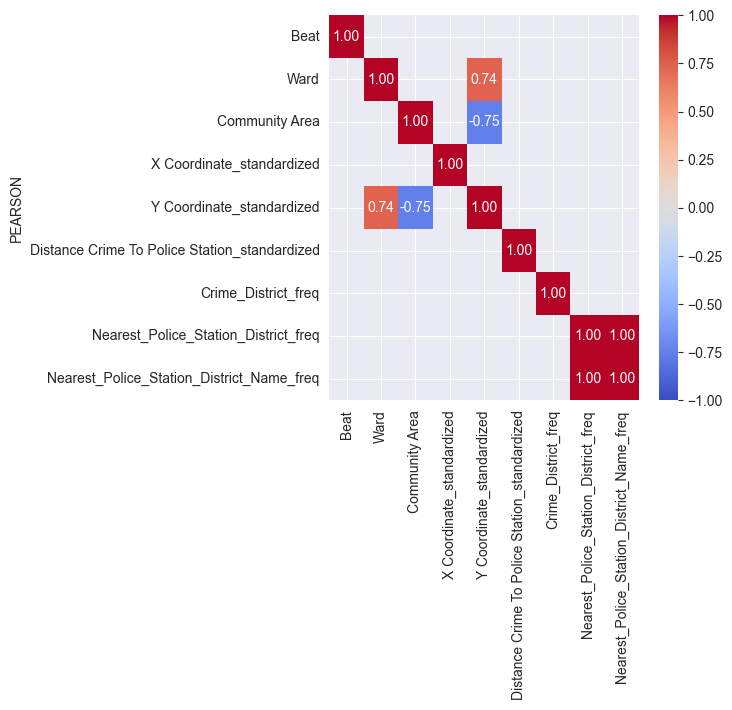

In [87]:
location_features = [
    'Beat', 
    'Ward',
    'Community Area', 
    'X Coordinate_standardized', 
    'Y Coordinate_standardized', 
    'Distance Crime To Police Station_standardized',
    'Crime_District_freq', 
    'Nearest_Police_Station_District_freq',
    'Nearest_Police_Station_District_Name_freq'
]

print(X_train.columns)
X_location = X_train[location_features]

umbral = 0.65

mask_for_heatmap = (X_location.corr(method='pearson').abs() < umbral)

plt.figure(figsize=(5,5))
sns.heatmap(
    X_location.corr(method='pearson'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.ylabel('PEARSON')
plt.show()



Matriz de correlación calculada
Shape: (10, 10)
TOP ID FEATURES MÁS CORRELACIONADAS CON 'Arrest'
X Coordinate_standardized                        0.051347
Distance Crime To Police Station_standardized    0.017909
Crime_District_freq                              0.017833
Beat                                             0.013779
Nearest_Police_Station_District_freq             0.012866
Nearest_Police_Station_District_Name_freq        0.012866
Ward                                             0.008870
Community Area                                   0.008069
Y Coordinate_standardized                        0.003939


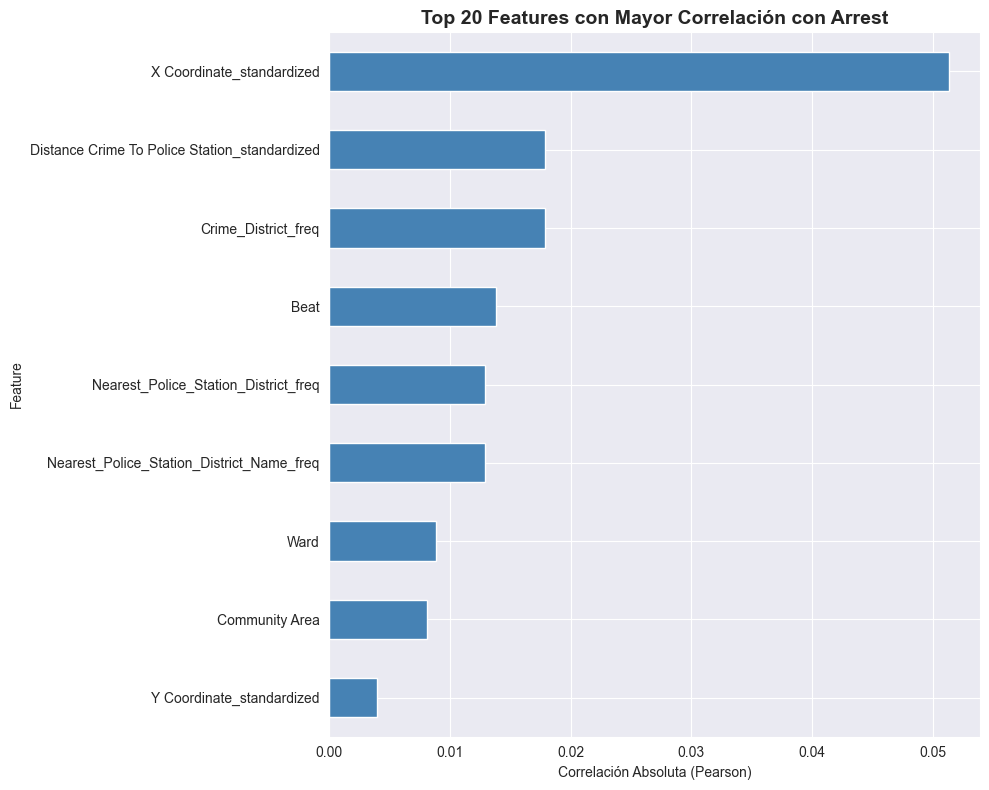

In [88]:
location_train_corr = X_location.copy()
location_train_corr['Arrest_tag'] = y_train

# Calcular matriz de correlación con Pearson
corr_matrix = location_train_corr.corr(method='pearson')

print("Matriz de correlación calculada")
print(f"Shape: {corr_matrix.shape}")
# Correlación de features con la variable target
target_corr = corr_matrix['Arrest_tag'].drop('Arrest_tag').abs().sort_values(ascending=False)

print("TOP ID FEATURES MÁS CORRELACIONADAS CON 'Arrest'")
print(target_corr.head(20).to_string())

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
target_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 20 Features con Mayor Correlación con Arrest', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlación Absoluta (Pearson)')
ax.set_ylabel('Feature')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Según lo visualizado en el heatmap se puede proceder a eliminar las features, Beat, Ward, Community Area y Nearest Police Station District Name Freq

In [89]:
print(X_train.columns)
X_train = X_train.drop(['Beat', 'Ward', 'Community Area', 'Nearest_Police_Station_District_Name_freq'], axis=1).copy()
X_test = X_test.drop(['Beat', 'Ward', 'Community Area', 'Nearest_Police_Station_District_Name_freq'], axis=1)
print(X_test.columns)


Index(['Beat', 'Ward', 'Community Area', 'Day_sin', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Day Time_Early Morning',
       'Day Time_Morning', 'Day Time_Night', 'Domestic_tag', 'IUCR_freq',
       'Primary_Type_freq', 'Location_Description_freq', 'FBI_Code_freq',
       'Crime_District_freq', 'Nearest_Police_Station_District_freq',
       'Nearest_Police_Station_District_Name_freq',
       'X Coordinate_standardized', 'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')
Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'FBI_Code_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dt

In [90]:
print(len(X_train.columns))
print(len(X_test.columns))

17
17


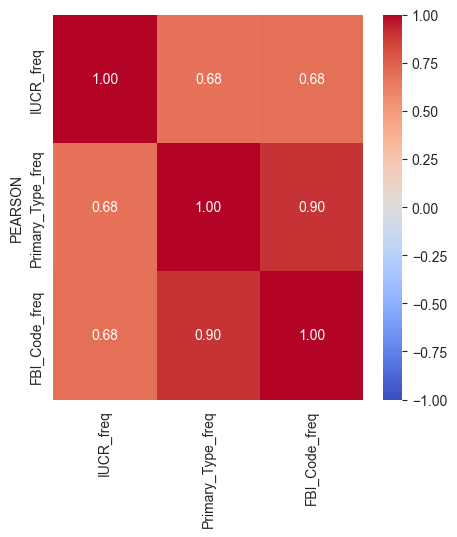

In [91]:
id_features = [
    'IUCR_freq', 
    'Primary_Type_freq',
    'FBI_Code_freq', 
]


X_id = X_train[id_features]

umbral = 0.65

mask_for_heatmap = (X_id.corr(method='pearson').abs() < umbral)

plt.figure(figsize=(5,5))
sns.heatmap(
    X_id.corr(method='pearson'), 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)
plt.ylabel('PEARSON')
plt.show()



Matriz de correlación calculada
Shape: (4, 4)
TOP ID FEATURES MÁS CORRELACIONADAS CON 'Arrest'
IUCR_freq            0.292459
FBI_Code_freq        0.269106
Primary_Type_freq    0.257079


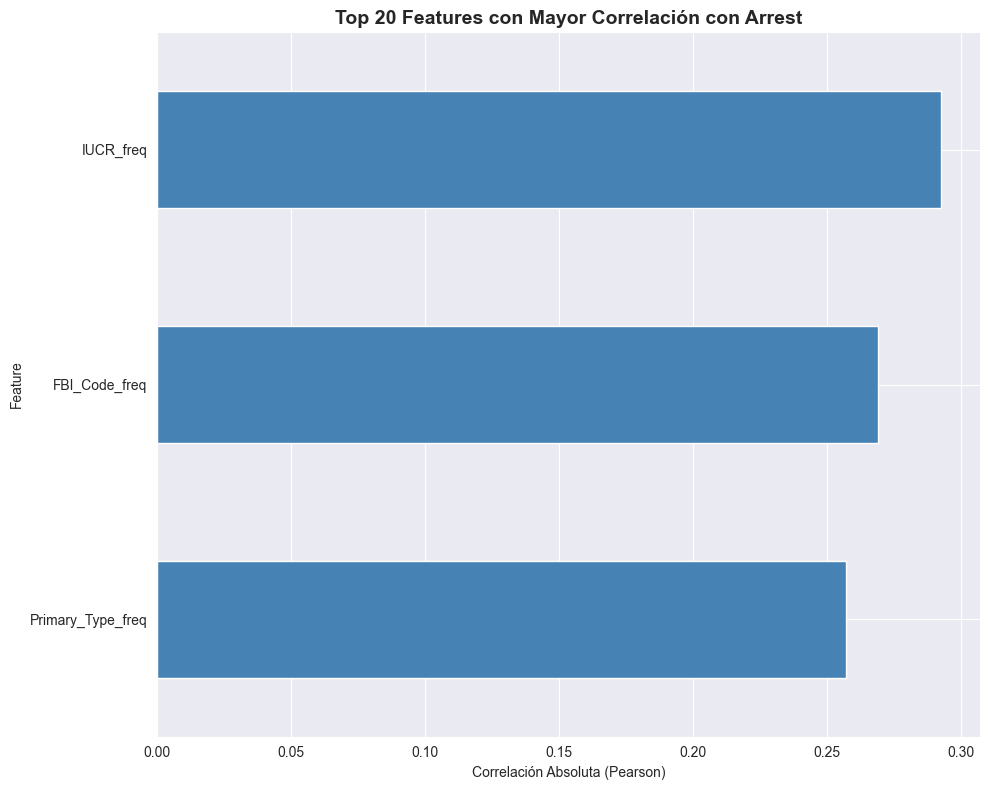

In [92]:
id_train_corr = X_id.copy()
id_train_corr['Arrest_tag'] = y_train

# Calcular matriz de correlación con Pearson
corr_matrix = id_train_corr.corr(method='pearson')

print("Matriz de correlación calculada")
print(f"Shape: {corr_matrix.shape}")
# Correlación de features con la variable target
target_corr = corr_matrix['Arrest_tag'].drop('Arrest_tag').abs().sort_values(ascending=False)

print("TOP ID FEATURES MÁS CORRELACIONADAS CON 'Arrest'")
print(target_corr.head(20).to_string())

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
target_corr.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 20 Features con Mayor Correlación con Arrest', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlación Absoluta (Pearson)')
ax.set_ylabel('Feature')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Se opta por eliminar solo FBI_Code_freq

In [93]:
print(X_train.columns)
X_train = X_train.drop(['FBI_Code_freq'], axis=1)
X_test = X_test.drop(['FBI_Code_freq'], axis=1)
print(X_test.columns)


Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'FBI_Code_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')
Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')


## Selección con ANOVA (F-test)

**Objetivo:** Identificar features numéricas con mayor poder predictivo sobre la variable target categórica.

**Hipótesis:**  
- H0: La media de la feature es igual para ambas clases (Arrest=0 y Arrest=1)  
- H1: Al menos una de las medias es diferente

**Criterio:** Mayor F-score = mayor poder predictivo

In [94]:
# Aplicar ANOVA solo a features numéricas
selector_anova = SelectKBest(score_func=f_classif, k='all')  # calcular todas
selector_anova.fit(X_train, y_train)

# Obtener scores y p-valores
anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': selector_anova.scores_,
    'P-Valor': selector_anova.pvalues_
}).sort_values('F-Score', ascending=False)

print("="*80)
print("ANOVA - F-TEST PARA FEATURES NUMÉRICAS")
print("="*80)
print(anova_scores.to_string(index=False))

ANOVA - F-TEST PARA FEATURES NUMÉRICAS
                                      Feature      F-Score       P-Valor
                                    IUCR_freq 18228.986314  0.000000e+00
                            Primary_Type_freq 13791.990175  0.000000e+00
                       Day Time_Early Morning   934.720269 8.519708e-205
                               Day Time_Night   831.174245 2.183114e-182
                    X Coordinate_standardized   515.197853 6.599357e-114
                                 Domestic_tag   420.161192  2.825092e-93
                             Day Time_Morning   252.179824  9.438520e-57
                    Location_Description_freq   241.446991  2.050778e-54
                                Season_Winter    72.095735  2.064154e-17
Distance Crime To Police Station_standardized    62.532311  2.634687e-15
                          Crime_District_freq    61.996732  3.457823e-15
                                Season_Summer    58.742780  1.805157e-14
            

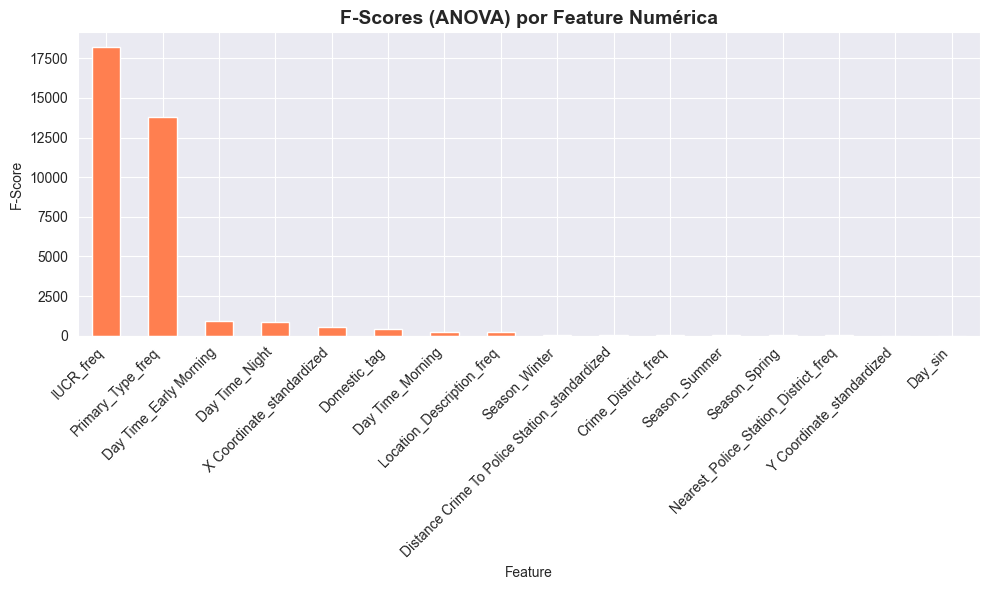


TOP 6 FEATURES NUMÉRICAS (ANOVA):
1. IUCR_freq                                | F-Score:   18228.99 | p-valor: 0.00e+00
2. Primary_Type_freq                        | F-Score:   13791.99 | p-valor: 0.00e+00
3. Day Time_Early Morning                   | F-Score:     934.72 | p-valor: 8.52e-205
4. Day Time_Night                           | F-Score:     831.17 | p-valor: 2.18e-182
5. X Coordinate_standardized                | F-Score:     515.20 | p-valor: 6.60e-114
6. Domestic_tag                             | F-Score:     420.16 | p-valor: 2.83e-93


In [95]:
# Visualizar F-scores
fig, ax = plt.subplots(figsize=(10, 6))
anova_scores.plot(x='Feature', y='F-Score', kind='bar', ax=ax, color='coral', legend=False)
ax.set_title('F-Scores (ANOVA) por Feature Numérica', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('F-Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Seleccionar top K features
k_anova = 6
top_anova = anova_scores.head(k_anova)['Feature'].tolist()
print(f"\nTOP {k_anova} FEATURES NUMÉRICAS (ANOVA):")
for i, feat in enumerate(top_anova, 1):
    score = anova_scores[anova_scores['Feature']==feat]['F-Score'].values[0]
    pval = anova_scores[anova_scores['Feature']==feat]['P-Valor'].values[0]
    print(f"{i}. {feat:40s} | F-Score: {score:10.2f} | p-valor: {pval:.2e}")

In [96]:
selector_anova = SelectFpr(score_func=f_classif, alpha=0.05)  # usar f_regression cuando la v.a. target es numérica
X_train_num_best = selector_anova.fit_transform(X_train, y_train)
selected_indices = selector_anova.get_support()  # Esta función me devuelve los features seleccionados
selected_features = X_train.columns[selected_indices]
p_values = selector_anova.pvalues_
scores = selector_anova.scores_[selected_indices]
print(f"Numéricas antes de filtrar: {X_train.columns}")
print("\nCaracterísticas seleccionadas (ANOVA):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")
print("\nP-valores de todas las características:")
for feature, p_valor in zip(X_train.columns, p_values):
    print(f"{feature}: {p_valor}")

Numéricas antes de filtrar: Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')

Características seleccionadas (ANOVA):
Season_Spring: 52.0890
Season_Summer: 58.7428
Season_Winter: 72.0957
Day Time_Early Morning: 934.7203
Day Time_Morning: 252.1798
Day Time_Night: 831.1742
Domestic_tag: 420.1612
IUCR_freq: 18228.9863
Primary_Type_freq: 13791.9902
Location_Description_freq: 241.4470
Crime_District_freq: 61.9967
Nearest_Police_Station_District_freq: 32.2686
X Coordinate_standardized: 515.1979
Distance Crime To Police Station_standardized: 62.5323

P-valores de todas las características:
Day_sin: 0.10

Conclusión:

* Las variables relacionadas con el tipo de crimen y el momento del día son las más relevantes para predecir arrestos.

* Las variables espaciales y estacionales muestran menor poder explicativo.

* Los resultados del ANOVA coinciden con el análisis de correlación, reforzando la validez de los hallazgos.

## Selección con Información Mutua (Mutual Information)

**Ventaja:** Captura relaciones no lineales entre features y target.

**Interpretación:** Mide cuánta "información" aporta una feature sobre el target.  
- MI = 0: Independientes  
- MI > 0: Existe dependencia

In [97]:
# Aplicar Información Mutua a TODAS las features
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_train, y_train)

# Obtener scores
mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI-Score': selector_mi.scores_
}).sort_values('MI-Score', ascending=False)

print("INFORMACIÓN MUTUA (MI) - TODAS LAS FEATURES")
print(mi_scores.head(30).to_string(index=False))

INFORMACIÓN MUTUA (MI) - TODAS LAS FEATURES
                                      Feature  MI-Score
                                    IUCR_freq  0.435477
                            Primary_Type_freq  0.350709
                    Location_Description_freq  0.249247
                                      Day_sin  0.196108
                    X Coordinate_standardized  0.099079
                    Y Coordinate_standardized  0.094043
Distance Crime To Police Station_standardized  0.070901
                               Day Time_Night  0.031976
         Nearest_Police_Station_District_freq  0.031922
                       Day Time_Early Morning  0.026603
                                Season_Summer  0.026361
                                Season_Spring  0.024654
                                Season_Winter  0.023486
                             Day Time_Morning  0.022359
                          Crime_District_freq  0.015915
                                 Domestic_tag  0.002013


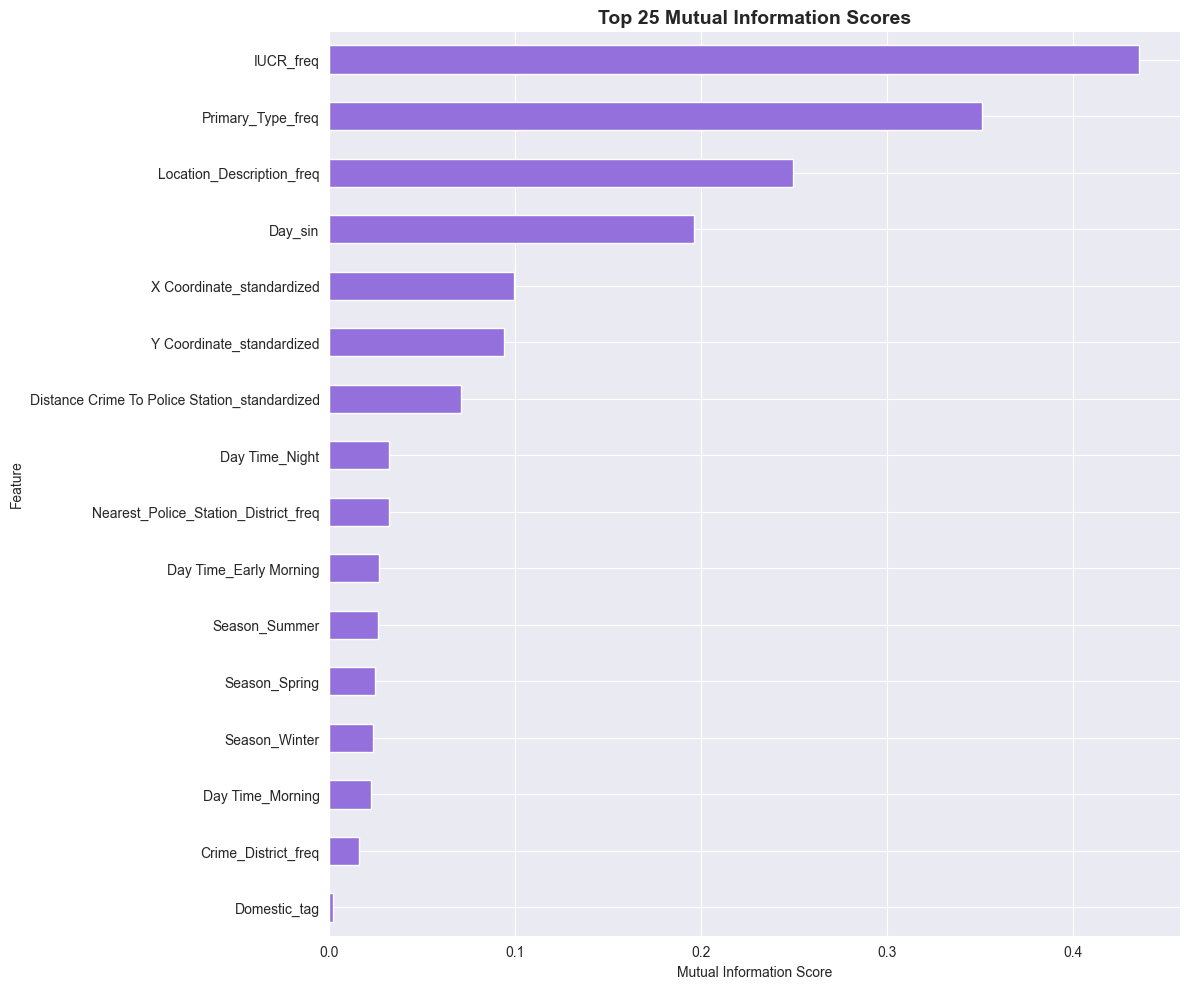


TOP 20 FEATURES (INFORMACIÓN MUTUA):
 1. IUCR_freq                                          | MI: 0.4355
 2. Primary_Type_freq                                  | MI: 0.3507
 3. Location_Description_freq                          | MI: 0.2492
 4. Day_sin                                            | MI: 0.1961
 5. X Coordinate_standardized                          | MI: 0.0991
 6. Y Coordinate_standardized                          | MI: 0.0940
 7. Distance Crime To Police Station_standardized      | MI: 0.0709
 8. Day Time_Night                                     | MI: 0.0320
 9. Nearest_Police_Station_District_freq               | MI: 0.0319
10. Day Time_Early Morning                             | MI: 0.0266
11. Season_Summer                                      | MI: 0.0264
12. Season_Spring                                      | MI: 0.0247
13. Season_Winter                                      | MI: 0.0235
14. Day Time_Morning                                   | MI: 0.0224
15. Crime_

In [98]:
# Visualizar MI-scores
fig, ax = plt.subplots(figsize=(12, 10))
mi_scores.head(25).plot(x='Feature', y='MI-Score', kind='barh', ax=ax, color='mediumpurple', legend=False)
ax.set_title('Top 25 Mutual Information Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Mutual Information Score')
ax.set_ylabel('Feature')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Seleccionar top K features
k_mi = 20
top_mi = mi_scores.head(k_mi)['Feature'].tolist()
print(f"\nTOP {k_mi} FEATURES (INFORMACIÓN MUTUA):")
for i, feat in enumerate(top_mi, 1):
    score = mi_scores[mi_scores['Feature']==feat]['MI-Score'].values[0]
    print(f"{i:2d}. {feat:50s} | MI: {score:.4f}")

In [ ]:
top_features = mi_scores[mi_scores['MI-Score'] > 0.05]['Feature']
X_train_top = X_train[top_features]
print(X_train.columns)
print(X_test.columns)
X_test_top = X_test[top_features]
# Unir X e y en un solo DataFrame
train_final = X_train_top.copy()
train_final['Arrest_tag'] = y_train.values

test_final = X_test_top.copy()
test_final['Arrest_tag'] = y_test.values

# Guardar datasets finales
train_final.to_csv("../datasets/chicago_crimes_and_stations_2024_final.csv", index=False)
test_final.to_csv("../datasets/chicago_crimes_and_stations_2024_final_test.csv", index=False)

Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')
Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')


Conclusiones:

* La información mutua confirma los resultados de las pruebas anteriores (ANOVA y correlación), pero además evidencia dependencias no lineales.

* Variables como Location_Description_freq y Day_sin muestran relevancia que no se reflejaba claramente en los métodos lineales, lo que resalta la ventaja de MI en la detección de relaciones más complejas.

* En conjunto, las variables relacionadas con el tipo de delito, el lugar del hecho y la temporalidad concentran la mayor cantidad de información útil para predecir arrestos.

* Las features IUCR_freq, Primary_Type_freq y Location_Description_freq son las más informativas, y deben priorizarse en las etapas siguientes del modelado.

* El análisis de Información Mutua confirma que la variable tipo de delito (IUCR, Primary_Type) y el contexto espacial del crimen (Location_Description) son los principales determinantes del arresto, seguidos por factores geográficos y temporales secundarios.

# PARTE 2: EXTRACCIÓN DE FEATURES

## PCA (Principal Component Analysis)

**Objetivo:** Reducir dimensionalidad transformando features en componentes principales ortogonales que capturan la máxima varianza.

**Ventajas:**
- Elimina multicolinealidad
- Reduce ruido
- Acelera entrenamiento

**Desventajas:**
- Pérdida de interpretabilidad
- Asume relaciones lineales

### Determinar Número Óptimo de Componentes

In [100]:
# Aplicar PCA con todos los componentes para análisis
pca_full = PCA(random_state=42)
pca_full.fit(X_train)

# Varianza explicada por cada componente
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


print("ANÁLISIS DE VARIANZA EXPLICADA - PCA")

print(f"\nVarianza explicada por los primeros 20 componentes:")
for i in range(min(20, len(explained_variance))):
    print(f"PC{i+1:2d}: {explained_variance[i]*100:5.2f}% | Acumulado: {cumulative_variance[i]*100:6.2f}%")

ANÁLISIS DE VARIANZA EXPLICADA - PCA

Varianza explicada por los primeros 20 componentes:
PC 1: 32.37% | Acumulado:  32.37%
PC 2: 21.56% | Acumulado:  53.93%
PC 3: 10.57% | Acumulado:  64.50%
PC 4:  9.52% | Acumulado:  74.02%
PC 5:  5.53% | Acumulado:  79.55%
PC 6:  5.42% | Acumulado:  84.97%
PC 7:  5.02% | Acumulado:  89.99%
PC 8:  3.98% | Acumulado:  93.96%
PC 9:  2.93% | Acumulado:  96.89%
PC10:  1.44% | Acumulado:  98.33%
PC11:  1.31% | Acumulado:  99.64%
PC12:  0.23% | Acumulado:  99.86%
PC13:  0.12% | Acumulado:  99.98%
PC14:  0.01% | Acumulado:  99.99%
PC15:  0.01% | Acumulado: 100.00%
PC16:  0.00% | Acumulado: 100.00%


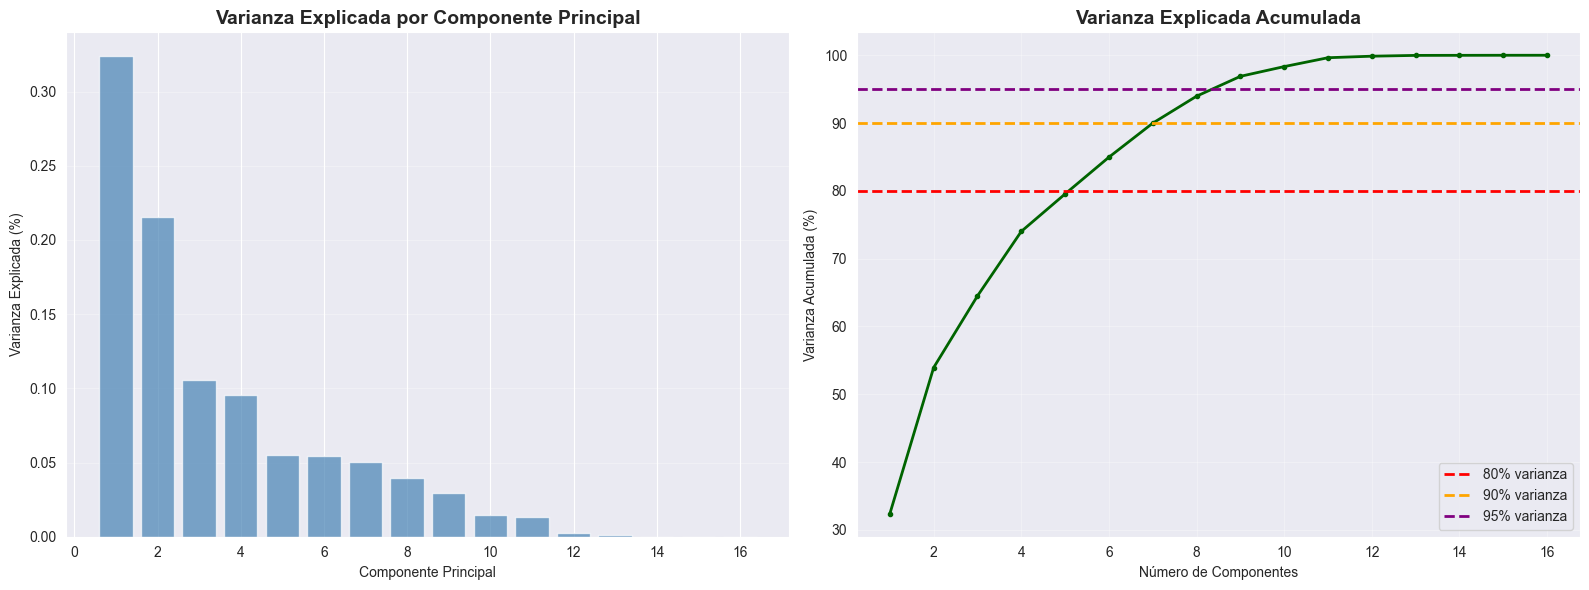

Componentes para 80% de varianza: 6
Componentes para 90% de varianza: 8
Componentes para 95% de varianza: 9


In [101]:
# Visualizar varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Varianza por componente
n_components_to_plot = min(30, len(explained_variance))
axes[0].bar(range(1, n_components_to_plot+1), explained_variance[:n_components_to_plot], 
            color='steelblue', alpha=0.7)
axes[0].set_title('Varianza Explicada por Componente Principal', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada (%)')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Varianza acumulada
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance*100, 
             marker='o', markersize=3, linewidth=2, color='darkgreen')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% varianza')
axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% varianza')
axes[1].axhline(y=95, color='purple', linestyle='--', linewidth=2, label='95% varianza')
axes[1].set_title('Varianza Explicada Acumulada', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada (%)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Encontrar número de componentes para diferentes umbrales
for threshold in [0.80, 0.90, 0.95]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Componentes para {threshold*100:.0f}% de varianza: {n_components}")

Conclusiones:

* De las variables originales si se conservan 8 componentes es posible explicar el 93% de la varianza.

* Esto reduce la complejidad del modelo y elimina correlaciones redundantes entre features.

* Los componentes resultantes servirán como nuevas variables base para las etapas de modelado y evaluación.

* El análisis PCA confirma que con 8 componentes principales se puede representar casi toda la información relevante del conjunto de datos, optimizando el equilibrio entre precisión, eficiencia y estabilidad.

### Aplicar PCA con Número Óptimo de Componentes

In [108]:
# Definir número de componentes (90% de varianza como compromiso)
variance_threshold = 0.90
n_components_optimal = np.argmax(cumulative_variance >= variance_threshold) + 1

print(f"Número óptimo de componentes para {variance_threshold*100:.0f}% varianza: {n_components_optimal}")
print(f"Reducción de dimensionalidad: {X_train.shape[1]} -> {n_components_optimal}")
print(f"Porcentaje de reducción: {(1 - n_components_optimal/X_train.shape[1])*100:.1f}%")

Número óptimo de componentes para 90% varianza: 8
Reducción de dimensionalidad: 16 -> 8
Porcentaje de reducción: 50.0%


In [109]:
X_test.columns

Index(['Day_sin', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Day Time_Early Morning', 'Day Time_Morning', 'Day Time_Night',
       'Domestic_tag', 'IUCR_freq', 'Primary_Type_freq',
       'Location_Description_freq', 'Crime_District_freq',
       'Nearest_Police_Station_District_freq', 'X Coordinate_standardized',
       'Y Coordinate_standardized',
       'Distance Crime To Police Station_standardized'],
      dtype='object')

In [104]:
# Aplicar PCA con n_components_optimal
pca = PCA(n_components=n_components_optimal, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Convertir a DataFrame
pca_columns = [f'PC{i+1}' for i in range(n_components_optimal)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)


print("PCA APLICADO EXITOSAMENTE")

print(f"Shape Train original: {X_train.shape}")
print(f"Shape Train PCA: {X_train_pca_df.shape}")
print(f"\nVarianza total explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")

X_train_pca_df.head()

PCA APLICADO EXITOSAMENTE
Shape Train original: (194897, 16)
Shape Train PCA: (194897, 8)

Varianza total explicada: 93.96%


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.596722,0.044927,-0.971905,-1.051767,-0.646838,-0.007242,-0.700557,0.860845
1,-0.798859,-0.046151,-0.418183,-0.628202,-0.628949,-0.025353,-0.714369,0.859359
2,-1.997050,0.942139,1.000027,0.284055,-0.339283,-0.180286,0.734188,0.008592
3,-1.885966,0.315495,0.489139,0.507542,-0.601794,-0.055073,-0.726143,0.840321
4,1.790782,-3.059824,-0.983523,0.163222,0.212375,0.926554,-0.103449,0.695803


### Análisis de Componentes Principales

In [105]:
# Contribución de features originales a cada componente principal
components_df = pd.DataFrame(
    pca.components_.T,
    columns=pca_columns,
    index=X_train.columns
)


print("COMPOSICIÓN DE LOS PRIMEROS 5 COMPONENTES PRINCIPALES")

for i in range(min(5, n_components_optimal)):
    pc_name = f'PC{i+1}'
    print(f"\n{pc_name} (Varianza explicada: {pca.explained_variance_ratio_[i]*100:.2f}%):")
    top_features = components_df[pc_name].abs().sort_values(ascending=False).head(10)
    for feat, weight in top_features.items():
        print(f"  {feat:50s}: {weight:7.4f}")

COMPOSICIÓN DE LOS PRIMEROS 5 COMPONENTES PRINCIPALES

PC1 (Varianza explicada: 32.37%):
  Y Coordinate_standardized                         :  0.7048
  X Coordinate_standardized                         :  0.6975
  Distance Crime To Police Station_standardized     :  0.1262
  Domestic_tag                                      :  0.0243
  Day Time_Morning                                  :  0.0078
  Location_Description_freq                         :  0.0070
  Nearest_Police_Station_District_freq              :  0.0045
  Season_Winter                                     :  0.0036
  Day Time_Night                                    :  0.0027
  Season_Spring                                     :  0.0027

PC2 (Varianza explicada: 21.56%):
  Distance Crime To Police Station_standardized     :  0.9684
  X Coordinate_standardized                         :  0.2402
  Y Coordinate_standardized                         :  0.0644
  Day_sin                                           :  0.0130
  Day Ti

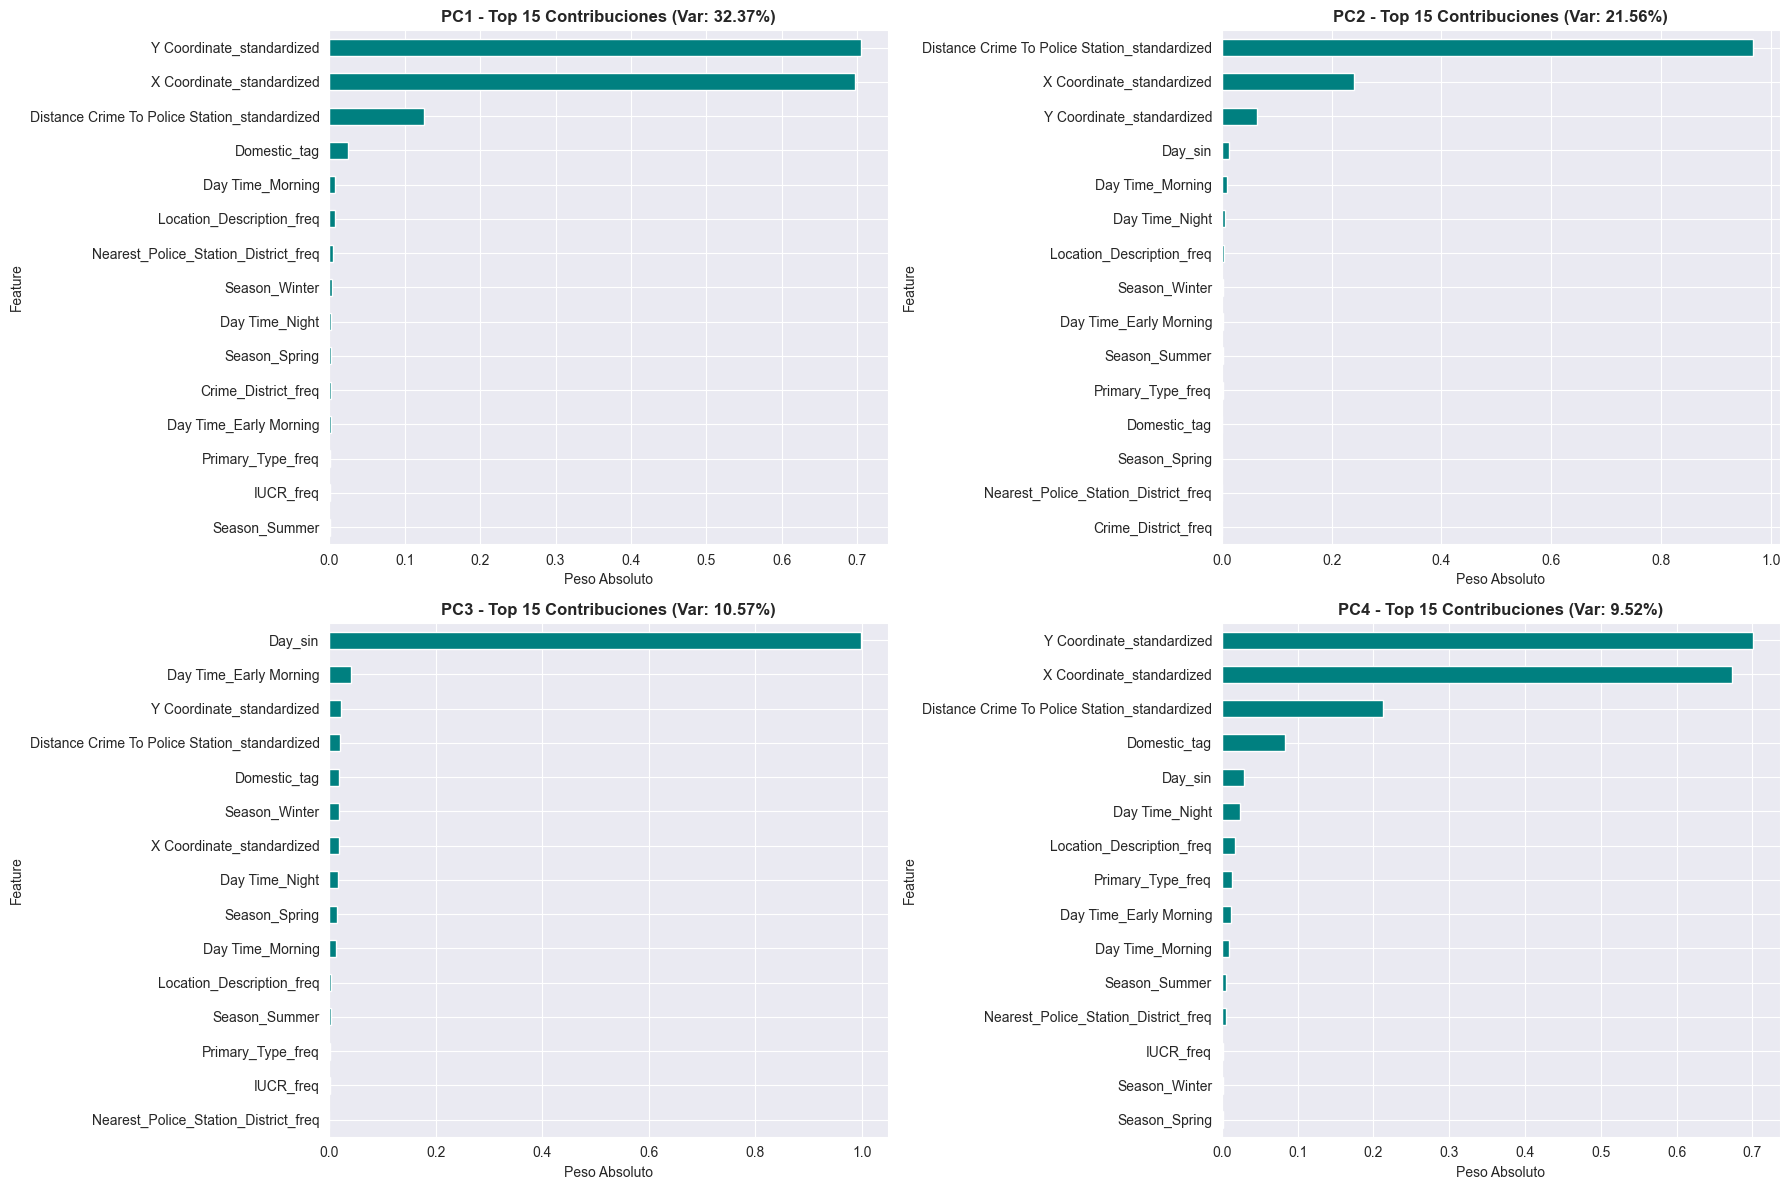

In [106]:
# Visualizar contribuciones de las primeras PCs
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i in range(min(4, n_components_optimal)):
    pc_name = f'PC{i+1}'
    top_contrib = components_df[pc_name].abs().sort_values(ascending=False).head(15)
    
    top_contrib.plot(kind='barh', ax=axes[i], color='teal')
    axes[i].set_title(f'{pc_name} - Top 15 Contribuciones (Var: {pca.explained_variance_ratio_[i]*100:.2f}%)', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Peso Absoluto')
    axes[i].set_ylabel('Feature')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

Conclusiones:

* Los primeros cuatro componentes concentran más del 73% de la varianza total, y describen principalmente patrones espaciales y temporales en los delitos.

* Las variables geográficas y temporales son las más determinantes en la estructura del dataset, seguidas por factores contextuales como la naturaleza del crimen.

* Esta representación comprimida permitirá entrenar modelos más eficientes, manteniendo la mayor parte de la información relevante.

* El PCA revela que los patrones espaciales y temporales son los ejes principales de variación en el conjunto de datos, y constituyen la base para los modelos predictivos de arresto posteriores.

In [107]:
# Unir X e y en un solo DataFrame
train_final = X_train_pca_df.copy()
train_final['Arrest_tag'] = y_train.values

test_final = X_test_pca_df.copy()
test_final['Arrest_tag'] = y_test.values

# Guardar datasets finales
train_final.to_csv("../datasets/chicago_crimes_and_stations_2024_final_PCA.csv", index=False)
test_final.to_csv("../datasets/chicago_crimes_and_stations_2024_final_PCA_test.csv", index=False)